# Benchmark Forecasting Models

In this notebook all relevant benchmarking models, namley Dense, LSTM, CNN, and Transformer are build, compiled, fitted, evaluated, plotted, and tuned. Therefore, the notebook ist structured into: 
- Data Handling
- Model Building

In [5]:
#Imports

import os
import tensorflow as tf
from keras import layers, models

from utils.modelgenerator import *
from utils.modelhandler import *
from utils.datahandler import *

ImportError: This version of TensorFlow Probability requires TensorFlow version >= 2.13; Detected an installation of version 2.11.0. Please upgrade TensorFlow to proceed.

### Data Handling
- **Get Data**: Load data to dataframe from User5. Data includes Date, temp, hour and Electricity consumption
- **Train, Validation and Test datasets**: Split Data into train, validation and test datasets
- **Normalize Data**: Normalize each feature of the the different datasets
- **Sequencing**: Take the 3 datasets and split them into sequences of length=sequence_length, then split the sequence into  X (features) and Y (labels)

In [2]:
#Get data 
cwd = os.path.normpath(os.getcwd())
df = pd.read_csv(cwd+'/data/df_with_final_features.csv', index_col='Date') #df = pd.read_csv('user5.csv')
df.index = pd.to_datetime(df.index)
#df = df[['User5', 'temp', 'rhum']]
df.fillna(0, inplace=True)

#Select only 1 User for testing
df = df[['User12', 'temp', 'rhum', 'wspd', 'PC1', 'hour sin', 'hour cos', 'User12_lag_24hrs']]
df.head(3)

,User12,temp,rhum,wspd,PC1,hour sin,hour cos,User12_lag_24hrs
Date,,,,,,,,
2012-07-08 00:00:00,0.152,9.8,85.0,0.0,-2.453691,0.000000,1.000000,0.225
2012-07-08 01:00:00,0.212,9.8,85.0,0.0,-2.453691,0.258819,0.965926,0.210
2012-07-08 02:00:00,0.218,9.8,85.0,0.0,-2.453691,0.500000,0.866025,0.221


In [3]:
#Train, Validation and Test datasets
sequence_length = 49
batch_size = 16
num_features = df.shape[1]

dh = Datahandler()

#Create Train, Validation and Test datasets
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

# Min max sclaing
train_df = dh.min_max_scaling(train_df)
val_df = dh.min_max_scaling(val_df)
test_df = dh.min_max_scaling(test_df)

# Sequencing
train_sequences = dh.create_sequences(train_df, sequence_length)
val_sequences = dh.create_sequences(val_df, sequence_length)
test_sequences = dh.create_sequences(test_df, sequence_length)

#Split into feature and label
X_train, y_train = dh.prepare_data(train_sequences, batch_size)
X_val, y_val = dh.prepare_data(val_sequences, batch_size)
X_test, y_test = dh.prepare_data(test_sequences, batch_size)

### Model Building
Build and test different model architecture

In [4]:
#General Hyperparameters
# #All models
horizon = 1
max_epochs = 100
m1 = ModelGenerator()
mh = Modelhandler()

loss = tf.keras.losses.MeanSquaredError()
metrics=[
    tf.keras.metrics.RootMeanSquaredError(), 
    tf.keras.metrics.MeanAbsolutePercentageError(),
    tf.keras.metrics.MeanAbsoluteError(),
]

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,mode='min')
timing_callback = TimingCallback()
custom_callback = CustomCallback()
callbacks=[early_stopping, timing_callback, custom_callback]

In [5]:
"""ensemble_user_result = m1.build_compile_evaluate_ensemble_model(X_train, y_train, X_val, y_val, X_test, y_test, horizon, batch_size, sequence_length, num_features, callbacks, "user1")
ensemble_user_result"""

'ensemble_user_result = m1.build_compile_evaluate_ensemble_model(X_train, y_train, X_val, y_val, X_test, y_test, horizon, batch_size, sequence_length, num_features, callbacks, "user1")\nensemble_user_result'

In [6]:
lightgbm_user_result = m1.build_compile_evaluate_lightgbm_model(train_df, val_df, test_df, "User12")
lightgbm_user_result

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 914
[LightGBM] [Info] Number of data points in the train set: 6014, number of used features: 7
[LightGBM] [Info] Start training from score 0.162982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\rs1044\bwSyncShare\02Python Code\MoE-based-FL-for-secure-STLF\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


,user,architecture,mse
0,User12,LightGBM,0.020101


Evaluation round:  1
Loss:  [0.011383104138076305, 0.1066916286945343, 155001.21875, 0.08098690956830978]
Evaluation round:  2
Loss:  [0.018123453482985497, 0.13462337851524353, 163572.046875, 0.09641891717910767]
Evaluation round:  3
Loss:  [0.010565992444753647, 0.10279101133346558, 116751.7421875, 0.06927601993083954]


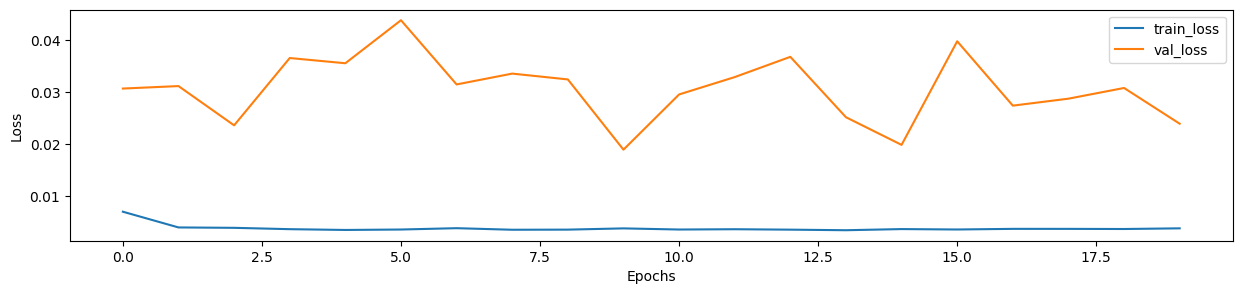

50/50 [==============================] - 0s 551us/step


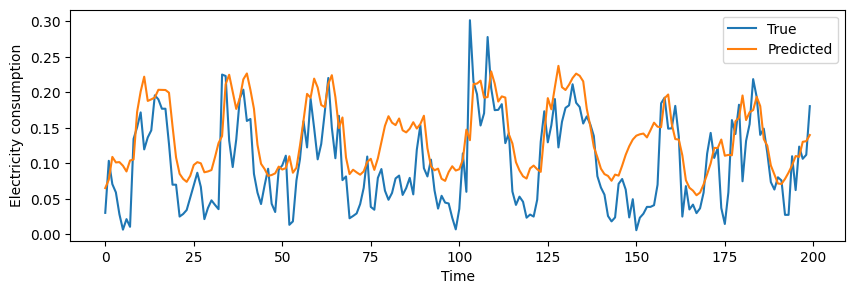

,model,hyperparameters,avg_num_eppochs,avg_train_time_epoch,avg_total_train_time,avg_test_rmse,avg_test_mae
0,dense,Layers2_units_64_64,24,0.407021,9.867407,0.106692,0.080987
0,dense,Layers2_units_64_64,21,0.399554,8.484649,0.134623,0.096419
0,dense,Layers2_units_64_64,20,0.404911,8.189245,0.102791,0.069276


In [5]:
#Fine Tuning Dense Model
units = 32
hyper_dense = 'Layers2_units_64_64'


dense_hyperparameter_results = pd.DataFrame(columns=['model', 'hyperparameters', 'avg_num_eppochs', 'avg_train_time_epoch', 'avg_total_train_time', 'avg_test_rmse', 'avg_test_mae'])


tuning_rounds = 3    
for i in range(tuning_rounds): 
    print("Evaluation round: ", i+1)
    dense_model = m1.build_dense_model(X_train, horizon, units=units)
    dense_model_history, dense_results, dense_summary  = mh.compile_fit_evaluate_model(dense_model, loss, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val, X_test, y_test, callbacks, hyper_dense)
    
    dense_hyperparameter_results = pd.concat([dense_hyperparameter_results, dense_summary])

mh.plot_model_predictions(dense_model, dense_model_history, y_test, X_test, batch_size)
dense_hyperparameter_results

Evaluation round:  1
Loss:  [0.014228321611881256, 0.11928252875804901, 150761.21875, 0.08145280927419662]
Evaluation round:  2
Loss:  [0.016259508207440376, 0.12751278281211853, 201174.203125, 0.09320294111967087]
Evaluation round:  3
Loss:  [0.016769710928201675, 0.12949791550636292, 176174.015625, 0.09856636077165604]


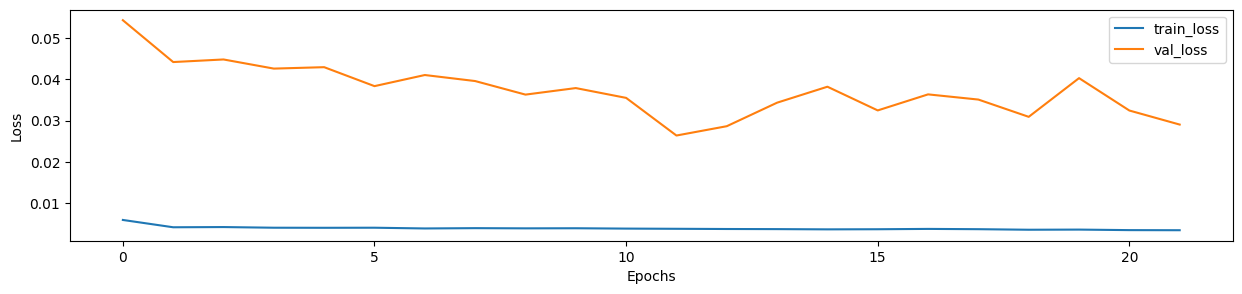

50/50 [==============================] - 0s 3ms/step


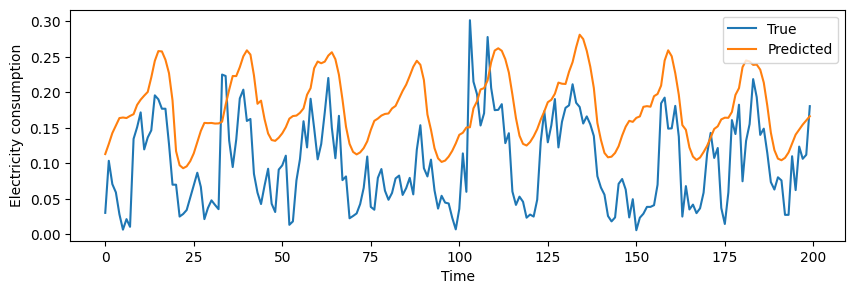

,model,hyperparameters,avg_num_eppochs,avg_train_time_epoch,avg_total_train_time,avg_test_rmse,avg_test_mae
0,sequential,Layers2_cells_16_16,22,3.618129,79.804414,0.119283,0.081453
0,sequential_1,Layers2_cells_16_16,28,3.599270,100.988121,0.127513,0.093203
0,sequential_2,Layers2_cells_16_16,22,3.580970,78.987403,0.129498,0.098566


In [6]:
#Fine Tuning LSTM Model
lstm_cells = 16
hyper_lstm = 'Layers2_cells_16_16'


lstm_hyperparameter_results = pd.DataFrame(columns=['model', 'hyperparameters', 'avg_num_eppochs', 'avg_train_time_epoch', 'avg_total_train_time', 'avg_test_rmse', 'avg_test_mae'])


tuning_rounds = 3    
for i in range(tuning_rounds): 
    print("Evaluation round: ", i+1)
    lstm_model = m1.build_lstm_model(X_train, horizon, lstm_cells=lstm_cells)
    lstm_model_history, lstm_results, lstm_summary  = mh.compile_fit_evaluate_model(lstm_model, loss, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val, X_test, y_test, callbacks, hyper_lstm)
    
    lstm_hyperparameter_results = pd.concat([lstm_hyperparameter_results, lstm_summary])

mh.plot_model_predictions(lstm_model, lstm_model_history, y_test, X_test, batch_size)
lstm_hyperparameter_results

Evaluation round:  1
Loss:  [0.011725032702088356, 0.1082821935415268, 161586.6875, 0.07752131670713425]
Evaluation round:  2
Loss:  [0.013212309218943119, 0.11494480818510056, 166631.046875, 0.081529401242733]
Evaluation round:  3
Loss:  [0.012426625937223434, 0.11147477477788925, 161642.6875, 0.08068869262933731]


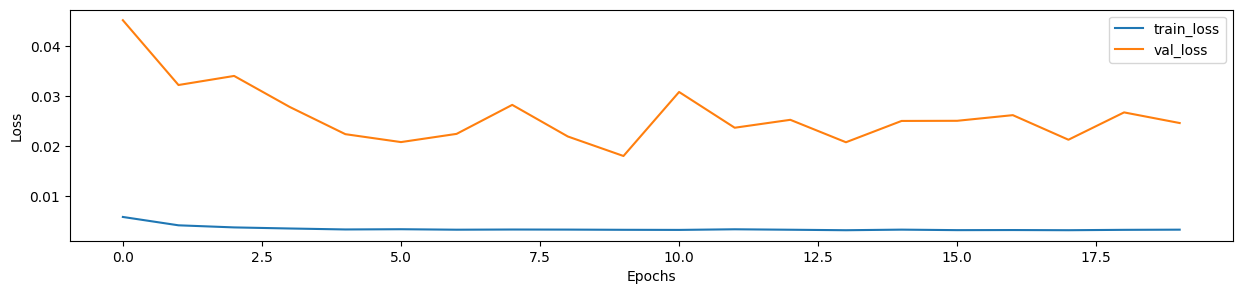

50/50 [==============================] - 1s 3ms/step


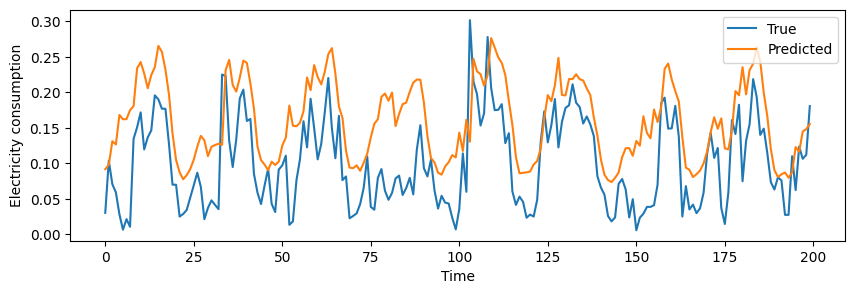

,model,hyperparameters,avg_num_eppochs,avg_train_time_epoch,avg_total_train_time,avg_test_rmse,avg_test_mae
0,sequential_3,Layers2_cells_32_32,14,3.814048,53.592472,0.108282,0.077521
0,sequential_4,Layers2_cells_32_32,23,3.650088,84.162051,0.114945,0.081529
0,sequential_5,Layers2_cells_32_32,20,3.704587,74.289880,0.111475,0.080689


In [7]:
#Fine Tuning BiLSTM Model
bilstm_cells = 4
hyper_bilstm = 'Layers2_cells_32_32'


bilstm_hyperparameter_results = pd.DataFrame(columns=['model', 'hyperparameters', 'avg_num_eppochs', 'avg_train_time_epoch', 'avg_total_train_time', 'avg_test_rmse', 'avg_test_mae'])


tuning_rounds = 3    
for i in range(tuning_rounds): 
    print("Evaluation round: ", i+1)
    bilstm_model = m1.build_bilstm_model(X_train, horizon, bilstm_cells=bilstm_cells)
    bilstm_model_history, bilstm_results, bilstm_summary  = mh.compile_fit_evaluate_model(bilstm_model, loss, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val, X_test, y_test, callbacks, hyper_bilstm)
    
    bilstm_hyperparameter_results = pd.concat([bilstm_hyperparameter_results, bilstm_summary])

mh.plot_model_predictions(bilstm_model, bilstm_model_history, y_test, X_test, batch_size)
bilstm_hyperparameter_results

Evaluation round:  1
Loss:  [0.016208043321967125, 0.12731081247329712, 137428.40625, 0.09039953351020813]
Evaluation round:  2
Loss:  [0.01673785038292408, 0.12937484681606293, 176063.0625, 0.08773785829544067]
Evaluation round:  3
Loss:  [0.014385138638317585, 0.11993806064128876, 158277.046875, 0.07811761647462845]


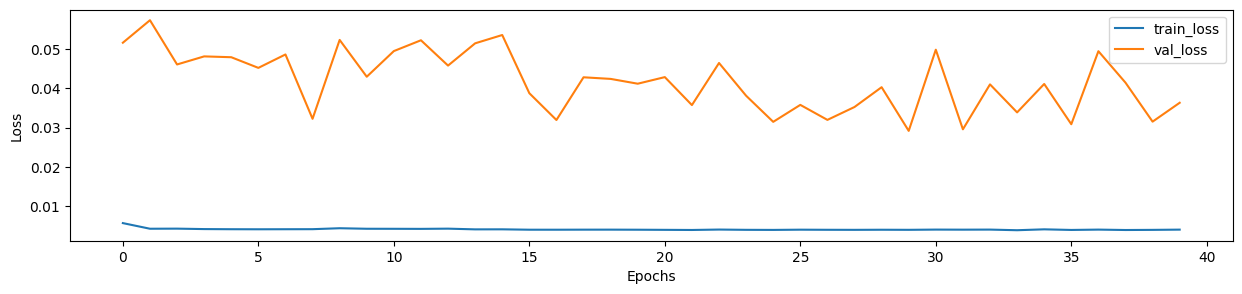

50/50 [==============================] - 0s 715us/step


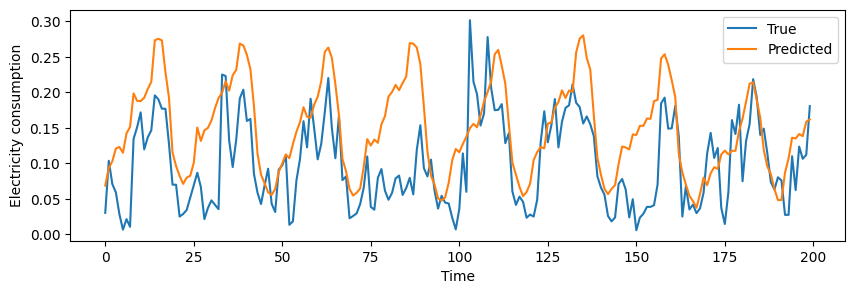

,model,hyperparameters,avg_num_eppochs,avg_train_time_epoch,avg_total_train_time,avg_test_rmse,avg_test_mae
0,sequential_6,Layers2_cells_32_32,20,0.610787,12.316868,0.127311,0.090400
0,sequential_7,Layers2_cells_32_32,19,0.683970,13.089289,0.129375,0.087738
0,sequential_8,Layers2_cells_32_32,40,0.635789,25.551589,0.119938,0.078118


In [8]:
#Fine Tuning CNN Model
filter = 32
kernel_size = 3
hyper_cnn = 'Layers2_cells_32_32'


cnn_hyperparameter_results = pd.DataFrame(columns=['model', 'hyperparameters', 'avg_num_eppochs', 'avg_train_time_epoch', 'avg_total_train_time', 'avg_test_rmse', 'avg_test_mae'])


tuning_rounds = 3    
for i in range(tuning_rounds): 
    print("Evaluation round: ", i+1)
    cnn_model = m1.build_cnn_model(X_train, horizon, filter=filter, kernel_size=kernel_size)
    cnn_model_history, cnn_results, cnn_summary  = mh.compile_fit_evaluate_model(cnn_model, loss, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val, X_test, y_test, callbacks, hyper_cnn)
    
    cnn_hyperparameter_results = pd.concat([cnn_hyperparameter_results, cnn_summary])

mh.plot_model_predictions(cnn_model, cnn_model_history, y_test, X_test, batch_size)
cnn_hyperparameter_results

Evaluation round:  1
Loss:  [0.022453604266047478, 0.14984527230262756, 183344.734375, 0.10125935822725296]
Evaluation round:  2
Loss:  [0.021733906120061874, 0.14742423593997955, 195383.4375, 0.10168923437595367]
Evaluation round:  3
Loss:  [0.021110238507390022, 0.14529362320899963, 191824.15625, 0.10055919736623764]


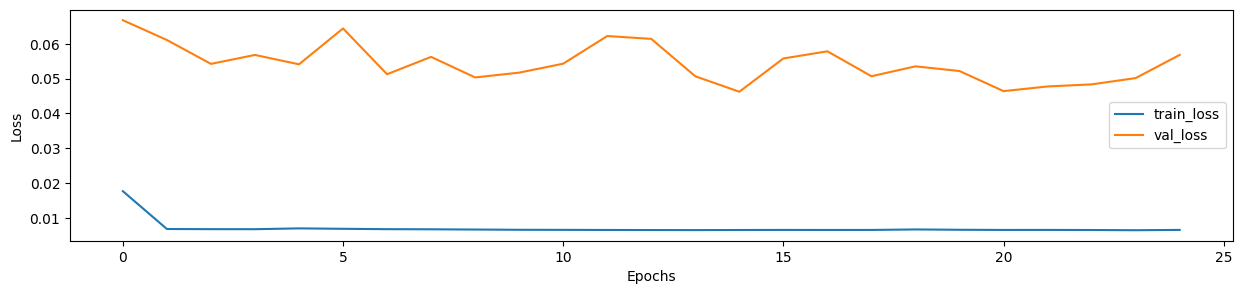

50/50 [==============================] - 0s 2ms/step


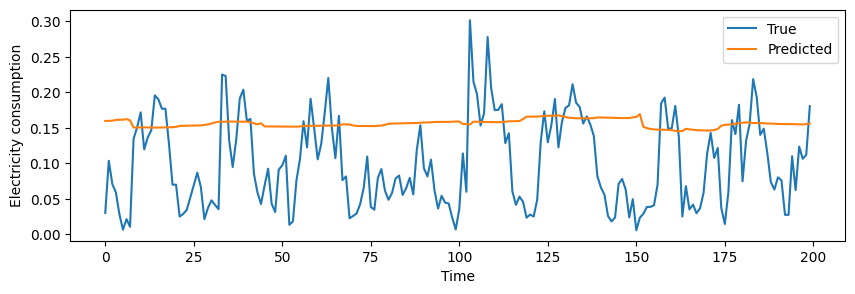

,model,hyperparameters,avg_num_eppochs,avg_train_time_epoch,avg_total_train_time,avg_test_rmse,avg_test_mae
0,model,Layers2_cells_32_32,13,1.646616,21.555470,0.149845,0.101259
0,model_1,Layers2_cells_32_32,19,1.573126,30.044977,0.147424,0.101689
0,model_2,Layers2_cells_32_32,25,1.563415,39.250250,0.145294,0.100559


In [9]:
#Fine Tune Transformer model
num_heads = 2
key_dim = 4

hyper_transformer = 'Layers2_cells_32_32'


transformer_hyperparameter_results = pd.DataFrame(columns=['model', 'hyperparameters', 'avg_num_eppochs', 'avg_train_time_epoch', 'avg_total_train_time', 'avg_test_rmse', 'avg_test_mae'])


tuning_rounds = 3    
for i in range(tuning_rounds): 
    print("Evaluation round: ", i+1)
    transformer_model = m1.build_transformer_model(X_train, horizon, num_features, num_heads=num_heads, key_dim=key_dim)
    transformer_model_history, transformer_results, transformer_summary  = mh.compile_fit_evaluate_model(transformer_model, loss, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val, X_test, y_test, callbacks, hyper_transformer)
    
    transformer_hyperparameter_results = pd.concat([transformer_hyperparameter_results, transformer_summary])

mh.plot_model_predictions(transformer_model, transformer_model_history, y_test, X_test, batch_size)
transformer_hyperparameter_results

### Basic models
The code below build, compiles, fits, evaluates and plots basic models.

In [5]:
"""
#Build Deep Learning Models
dense_model = m1.build_dense_model(X_train, horizon, units=64)
lstm_model = m1.build_lstm_model(X_train, horizon, lstm_cells=64)
cnn_model = m1.build_cnn_model(X_train, horizon, filter=64, kernel_size=3)
bilstm_model = m1.build_bilstm_model(X_train, horizon, bilstm_cells=32)
probability_model = m1.build_probability_model(X_train, horizon, units=128)
transformer_model = m1.build_transformer_model(X_train, horizon, num_features, num_heads=2, key_dim=4)

#Compile, fit, evaluate deep learning models
history_dense_model  = mh.compile_fit_evaluate_model(dense_model, loss, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val, X_test, y_test, callbacks)
history_lstm_model  = mh.compile_fit_evaluate_model(lstm_model, loss, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val, X_test, y_test, callbacks)
history_cnn_model  = mh.compile_fit_evaluate_model(cnn_model, loss, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val, X_test, y_test, callbacks)
history_bilstm_model  = mh.compile_fit_evaluate_model(bilstm_model, loss, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val, X_test, y_test, callbacks)
history_probability_model  = mh.compile_fit_evaluate_model(probability_model, loss, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val, X_test, y_test, callbacks)
history_transformer_model  = mh.compile_fit_evaluate_model(transformer_model, loss, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val, X_test, y_test, callbacks)


#Plot deep learning models
mh.plot_model_predictions(dense_model, history_dense_model, y_test, X_test, batch_size)
mh.plot_model_predictions(lstm_model, history_dense_model, y_test, X_test, batch_size)
mh.plot_model_predictions(cnn_model, history_dense_model, y_test, X_test, batch_size)
mh.plot_model_predictions(bilstm_model, history_dense_model, y_test, X_test, batch_size)
mh.plot_model_predictions(dense_model, history_probability_model, y_test, X_test, batch_size)
mh.plot_model_predictions(dense_model, history_transformer_model, y_test, X_test, batch_size)
"""

'\n#Build Deep Learning Models\ndense_model = m1.build_dense_model(X_train, horizon, units=64)\nlstm_model = m1.build_lstm_model(X_train, horizon, lstm_cells=64)\ncnn_model = m1.build_cnn_model(X_train, horizon, filter=64, kernel_size=3)\nbilstm_model = m1.build_bilstm_model(X_train, horizon, bilstm_cells=32)\nprobability_model = m1.build_probability_model(X_train, horizon, units=128)\ntransformer_model = m1.build_transformer_model(X_train, horizon, num_features, num_heads=2, key_dim=4)\n\n#Compile, fit, evaluate deep learning models\nhistory_dense_model  = mh.compile_fit_evaluate_model(dense_model, loss, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val, X_test, y_test, callbacks)\nhistory_lstm_model  = mh.compile_fit_evaluate_model(lstm_model, loss, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val, X_test, y_test, callbacks)\nhistory_cnn_model  = mh.compile_fit_evaluate_model(cnn_model, loss, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val

In [7]:
"""
#Statistical models
svm_model = m1.build_svm_model(kernel='linear')
elasticnet_regression_model = m1.build_elasticnet_regression_model(alpha=0.0001, l1_ratio=0.5)
decisiontree_model = m1.build_decisiontree_model()
randomforrest_model = m1.build_randomforrest_model(n_estimators=10)
k_neighbors_model = m1.build_k_neighbors_model(n_neighbors=5)

mh.statistical_model_compile_fit_evaluate(X_train, y_train, X_test, y_test, decisiontree_model)
mh.statistical_model_compile_fit_evaluate(X_train, y_train, X_test, y_test, svm_model)
mh.statistical_model_compile_fit_evaluate(X_train, y_train, X_test, y_test, elasticnet_regression_model)
mh.statistical_model_compile_fit_evaluate(X_train, y_train, X_test, y_test, randomforrest_model)
mh.statistical_model_compile_fit_evaluate(X_train, y_train, X_test, y_test, k_neighbors_model)
"""

Transformer:  (None, 48, 32)
Transformer:  (None, 48, 1)


"\n#Build Deep Learning Models\ndense_model = m1.build_dense_model(X_train, horizon, units=64)\nlstm_model = m1.build_lstm_model(X_train, horizon, lstm_cells=64)\ncnn_model = m1.build_cnn_model(X_train, horizon, filter=64, kernel_size=3)\nbilstm_model = m1.build_bilstm_model(X_train, horizon, bilstm_cells=32)\nprobability_model = m1.build_probability_model(X_train, horizon, units=128)\ntransformer_model = m1.build_transformer_model(X_train, horizon, num_features, num_heads=2, key_dim=4)\n\n#Compile, fit, evaluate deep learning models\nhistory_dense_model  = mh.compile_fit_evaluate_model(dense_model, loss, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val, X_test, y_test, callbacks)\nhistory_lstm_model  = mh.compile_fit_evaluate_model(lstm_model, loss, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val, X_test, y_test, callbacks)\nhistory_cnn_model  = mh.compile_fit_evaluate_model(cnn_model, loss, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val